# YouTube Video Summary

This is an agent that can provide a summary of the latest YouTube videos on a specific topic.

This agent is built with [LangGraph](https://langchain-ai.github.io/langgraph/) and [LangChain](https://python.langchain.com/docs/introduction/) using Claude 3.5 Sonnet.

It also uses [LangSmith](https://docs.smith.langchain.com/) to track the execution of the agent.

## 1. Setup

Let's install the relevant LangGraph and LangChain packages.

In [14]:
%pip install --upgrade --quiet  langchain-community
%pip install --upgrade --quiet  langchain-core
%pip install --upgrade --quiet  langchain-anthropic
%pip install --upgrade --quiet  langgraph
%pip install --upgrade --quiet  langsmith

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
embedchain 0.1.126 requires langsmith<0.2.0,>=0.1.17, but you have langsmith 0.3.7 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


Let's install two additional packages to search and get transcripts for YouTube videos.


In [2]:
%pip install --upgrade --quiet  youtube_search
%pip install --upgrade --quiet  youtube_transcript_api

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Let's import the necessary packages.

In [21]:
import os
import re
import uuid
from typing import Dict, List, Tuple, Annotated, TypedDict
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import Tool
from langchain_community.tools import YouTubeSearchTool
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langsmith import Client as LangSmithClient
from youtube_transcript_api import YouTubeTranscriptApi
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

## 2. Environment Variables

Let's set the environment variables.

In [4]:
from helpers import _set_env

_set_env("ANTHROPIC_API_KEY")
_set_env("LANGCHAIN_API_KEY")
_set_env("LANGCHAIN_TRACING_V2")

## 3. LLM and Tools

Let's initialize the LLM and tools that our agent will use.

In [5]:
llm = ChatAnthropic(model="claude-3-5-sonnet-latest", temperature=0.7)

In [6]:
youtube_search = YouTubeSearchTool()

In [7]:
tools = [
    Tool(
        name="youtube_search",
        func=youtube_search.run,
        description="Search for YouTube videos on a specific topic"
    )
]

## 4. Helper Functions

Let's define two helper functions to extract the video ID from a YouTube URL and to get the transcript for a YouTube video.

In [8]:
def extract_video_id(url: str) -> str:
    """Extract YouTube video ID from URL."""
    patterns = [
        r'(?:youtube\.com\/watch\?v=|youtu.be\/)([\w-]+)',
        r'v=([\w-]+)',
        r'^([\w-]+)$'
    ]
    for pattern in patterns:
        if match := re.search(pattern, url):
            return match.group(1)
    return url

def get_video_transcript(video_id: str) -> str:
    """Get transcript for a YouTube video."""
    try:
        transcript_list = YouTubeTranscriptApi.get_transcript(video_id)
        return " ".join(entry["text"] for entry in transcript_list)
    except Exception as e:
        return f"Could not fetch transcript: {str(e)}"

## 5. Nodes

Let's define the nodes that our agent will use.

In [9]:
def search_videos(state):
    """Node to search for YouTube videos."""
    messages = state["messages"]
    human_input = messages[-1].content
    
    # Generate search terms using LLM
    search_prompt = f"""
    Create 5 YouTube search terms for the following topic: {human_input} 
    The search terms should be specific and relevant to the topic.
    If possible, the search terms should be about a recent trend on the given topic.
    Only return the search terms separated by new lines, no other text.
    
    For example if the topic is "AI", you'd return:
    
    <RETURN>
    AI
    AI trends
    AI technologies
    AI applications
    AI innovations
    </RETURN>
    """
    search_terms = llm.invoke(search_prompt).content
    
    print("🤖: Search terms:", ", ".join(search_terms.split("\n")))
    
    # Search videos for each term
    all_results = []
    for term in search_terms.split("\n"):
        if term.strip():
            results = youtube_search.run(term.strip())
            all_results.append(results)
        
    print(f"🤖: Found {len(all_results)} results for the search terms")
    
    return {"messages": messages + [SystemMessage(content=str(all_results))]}

def process_videos(state):
    """Node to process videos and get transcripts."""
    messages = state["messages"]
    search_results = messages[-1].content
    
    # Extract video IDs and get transcripts
    video_details = []
    for url in re.findall(r'https://[^\s]+', search_results):
        video_id = extract_video_id(url)
        if video_id:
            transcript = get_video_transcript(video_id)
            video_details.append({ "url": url, "transcript": transcript })
    
    return {"messages": messages + [SystemMessage(content=str(video_details))]}

def create_summary(state):
    """Node to create research summary."""
    messages = state["messages"]
    video_details = messages[-1].content
    
    summary_prompt = """
    Create a detailed research summary from the given content.
    The content is a list of YouTube videos and their transcripts.
    
    Include:
    1. Executive summary (2-3 sentences)
    2. Main findings and insights in bullet points (12-15 bullet points across 3-5 themes)
    3. Key points and interesting remarks from each video (3-5 bullet points per video)
    4. Citations with URLs at the bottom (You MUST include the URL in the citation)
    
    For each section include a title in uppercase and make sure there is an empty line before and after the title.
    
    Content: {video_details}
    """
    
    summary_content = llm.invoke(summary_prompt.format(video_details=video_details)).content
    
    return {"messages": messages + [SystemMessage(content=summary_content)]}

## 6. Graph Setup

Let's define the state and the workflow graph that our agent will use.

The graph defines how our agent processes videos:
1. Search for relevant videos
2. Process videos and extract transcripts
3. Create a final summary

This uses LangGraph's `StateGraph` to manage the workflow and state transitions between different processing nodes.

In [10]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
# Create the workflow graph
graph_builder = StateGraph(State)
    
# Add nodes
graph_builder.add_node("search_videos", search_videos)
graph_builder.add_node("process_videos", process_videos)
graph_builder.add_node("create_summary", create_summary)
    
# Define edges
graph_builder.set_entry_point("search_videos")
graph_builder.add_edge("search_videos", "process_videos")
graph_builder.add_edge("process_videos", "create_summary")

# Add memory saver
checkpointer = MemorySaver()

# Compile the workflow
graph = graph_builder.compile(checkpointer=checkpointer)

Let's visualize the graph.

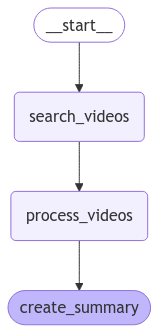

In [12]:
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

## 7. Run the agent

Let's now run the agent. The user has to input a topic and the agent will provide a summary of the latest YouTube videos on that topic.

In [22]:
print("🤖: Hi there. I can provide a summary of the latest YouTube videos on a specific topic. Let's start!")
human_input = input("👤 Topic: ")

messages = [HumanMessage(content=human_input)]
config = {"run_id": uuid.uuid4(), "configurable": {"thread_id": "1"}}
result = graph.invoke({"messages": messages}, config)

print("🤖:", result["messages"][-1].content)

🤖: Hi there. I can provide a summary of the latest YouTube videos on a specific topic. Let's start!
🤖: Search terms: AGI future predictions 2024, AGI vs narrow AI explained, AGI breakthrough latest news, AGI safety concerns, AGI development timeline debate
🤖: Found 5 results for the search terms
🤖: Here's a detailed research summary from the provided YouTube content:

EXECUTIVE SUMMARY
Recent discussions and predictions around Artificial General Intelligence (AGI) suggest a timeline of 2027-2029 for achieving human-level AI capabilities, with significant developments expected in the interim. Industry leaders and researchers debate the implications, safety concerns, and potential societal impacts, while highlighting the need for proper governance and alignment with human values.

MAIN FINDINGS AND INSIGHTS

Technical Development:
- Current AI models are considered narrow AI, with AGI development expected within 3-5 years
- Major breakthroughs in language models (GPT-5, Claude 4) anticip

## 8. Analytics and metrics

Let's now review the execution metrics and costs for our agent run.

In [48]:
langsmith_client = LangSmithClient()
run = next(langsmith_client.list_runs(id=[config["run_id"]]))

print(f"Total Tokens: {run.total_tokens}")
print(f"Prompt Tokens: {run.prompt_tokens}")
print(f"Completion Tokens: {run.completion_tokens}")
print(f"Execution Time: {run.end_time - run.start_time}")

# NOTE: The total cost is not available for certain models (e.g. Claude 3.5 Sonnet)
if run.total_cost:
    print(f"Total Cost: ${run.total_cost:.4f}")


Total Tokens: 39297
Prompt Tokens: 38489
Completion Tokens: 808
Execution Time: 0:00:33.887768
